In [ ]:
# !pip install pytorch_lightning

In [ ]:
import sys
import os

def is_colab_env():
    return "google.colab" in sys.modules

def mount_google_drive(drive_dir="/content/drive/", repo_dir="MyDrive/repositories/deepfake-detection"):
    # mount google drive
    from google.colab import drive
    drive.mount(drive_dir)

    # change to correct working directory
    import os
    repo_dir = f"{drive_dir}{repo_dir}"
    os.chdir(repo_dir)
    print(os.listdir()) # verify content
    return repo_dir

def resolve_path(levels_deep=3):
    if is_colab_env():
        return mount_google_drive()
    else:
        # Get the directory of the current script
        current_dir = os.path.dirname(os.path.abspath('__file__'))

        # Construct the path to the parent directory
        for i in range(levels_deep):
            current_dir = os.path.dirname(current_dir)

        # Add the parent directory to sys.path
        sys.path.append(current_dir)
        print(sys.path)
        return current_dir

proj_dir = resolve_path(2)

In [ ]:
from PIL import Image

In [ ]:
# import local config
import config

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
from tqdm import tqdm

In [ ]:
output_dir = config.ANALYSIS_DIR
grad_cam_dir = os.path.join(output_dir, 'gradcam')
os.makedirs(grad_cam_dir, exist_ok=True)

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
model_id = "dwt_resnet18"
model_checkpoint_dir = f"{proj_dir}/{config.CHECKPOINTS_DIR}/{model_id}"

In [ ]:
from src.models.resnet import ResNetClassifier

In [ ]:
class ImageDataset(Dataset):
    """Dataset for loading images from real/fake directories"""
    def __init__(self, real_dir, fake_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []

        # Load real images (label 0)
        real_path = Path(real_dir)
        for img_path in real_path.glob('*'):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                self.images.append(str(img_path))
                self.labels.append(0)

        # Load fake images (label 1)
        fake_path = Path(fake_dir)
        for img_path in fake_path.glob('*'):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                self.images.append(str(img_path))
                self.labels.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)

        # Keep original format (don't convert to RGB if it's 4-channel)
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label, img_path


class GradCAM:
    """Grad-CAM implementation for model explainability"""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        """Generate Grad-CAM heatmap"""
        self.model.eval()

        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1)

        # Backward pass
        self.model.zero_grad()
        class_loss = output[0, target_class]
        class_loss.backward()

        # Generate CAM
        gradients = self.gradients[0]  # [C, H, W]
        activations = self.activations[0]  # [C, H, W]

        # Global average pooling of gradients
        weights = gradients.mean(dim=(1, 2))  # [C]

        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # ReLU and normalize
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy(), output


def overlay_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """Overlay heatmap on original image"""
    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Overlay
    overlayed = (1 - alpha) * image + alpha * heatmap_colored
    overlayed = np.clip(overlayed, 0, 255).astype(np.uint8)

    return overlayed


def predict_with_gradcam(model, dataloader, target_layer, device='cuda', save_dir='gradcam_results'):
    """Make predictions and generate Grad-CAM visualizations"""
    model.eval()
    model.to(device)

    # Create save directory
    save_path = Path(save_dir)
    save_path.mkdir(exist_ok=True)

    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)

    results = []

    # Remove torch.no_grad() context since we need gradients for Grad-CAM
    for batch_idx, (images, labels, img_paths) in enumerate(dataloader):
        images = images.to(device)

        # Process each image in batch
        for i in range(images.size(0)):
            img_tensor = images[i:i+1].requires_grad_(True)
            true_label = labels[i].item()
            img_path = img_paths[i]

            # Generate Grad-CAM and get predictions
            cam, outputs = gradcam.generate_cam(img_tensor)

            # Get prediction and confidence
            probs = F.softmax(outputs, dim=1)
            pred_label = outputs.argmax(dim=1).item()
            confidence = probs[0, pred_label].item()

            # Convert tensor to image for visualization
            img_np = img_tensor[0].detach().cpu().numpy().transpose(1, 2, 0)  # [4, H, W] -> [H, W, 4]

            # For 4-channel images, visualize only first 3 channels as RGB
            if img_np.shape[2] == 4:
                # Denormalize if needed (adjust mean/std based on your normalization)
                mean = np.array([0.485, 0.456, 0.406, 0.5]).reshape(1, 1, 4)  # Add 4th channel mean
                std = np.array([0.229, 0.224, 0.225, 0.25]).reshape(1, 1, 4)  # Add 4th channel std
                img_np = std * img_np + mean
                img_np = np.clip(img_np, 0, 1)

                # Take first 3 channels for visualization
                img_np_rgb = (img_np[:, :, :3] * 255).astype(np.uint8)
            else:
                # Standard 3-channel denormalization
                mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
                std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
                img_np = std * img_np + mean
                img_np_rgb = np.clip(img_np * 255, 0, 255).astype(np.uint8)

            # Overlay heatmap
            overlayed = overlay_heatmap(img_np_rgb, cam)

            # Save visualization
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(img_np_rgb)
            axes[0].set_title('Original Image (RGB channels)')
            axes[0].axis('off')

            axes[1].imshow(cam, cmap='jet')
            axes[1].set_title('Grad-CAM Heatmap')
            axes[1].axis('off')

            axes[2].imshow(overlayed)
            axes[2].set_title(f'Overlay\nPred: {"Fake" if pred_label == 1 else "Real"} ({confidence:.2%})\nTrue: {"Fake" if true_label == 1 else "Real"}')
            axes[2].axis('off')

            plt.tight_layout()
            save_name = f'{Path(img_path).stem}_gradcam.png'
            plt.savefig(save_path / save_name, dpi=150, bbox_inches='tight')
            plt.close()

            # Store results
            results.append({
                'image_path': img_path,
                'true_label': 'fake' if true_label == 1 else 'real',
                'predicted_label': 'fake' if pred_label == 1 else 'real',
                'confidence': confidence,
                'correct': true_label == pred_label
            })

            print(f"Processed: {Path(img_path).name} - Pred: {'Fake' if pred_label == 1 else 'Real'} ({confidence:.2%})")

    return results

In [ ]:
# def overlay_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
#     """Overlay heatmap on original image"""
#     # Resize heatmap to match image size
#     heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

#     # Convert heatmap to RGB
#     heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
#     heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

#     # Overlay
#     overlayed = (1 - alpha) * image + alpha * heatmap_colored
#     overlayed = np.clip(overlayed, 0, 255).astype(np.uint8)

#     return overlayed


In [ ]:
REAL_DIR = f'{proj_dir}/analysis/samples/real'
FAKE_DIR = f'{proj_dir}/analysis/samples/fake'

# checkpoint = "lightning_logs/version_0/checkpoints/epoch=13-step=177520.ckpt" # rgb_dwt
checkpoint = "lightning_logs/version_0/checkpoints/epoch=7-step=202880.ckpt" # dwt
MODEL_PATH = f'{model_checkpoint_dir}/{checkpoint}'
BATCH_SIZE = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
NUM_CHANNELS = 4  # Change this to 1, 2, 3, 4, or 7 based on your model

# Get normalization parameters
# mean, std = get_normalization_params(NUM_CHANNELS)

In [ ]:
from src.transforms.frequency import get_transforms
dwt_transforms = get_transforms("wavelet")
# from src.transforms.fusion import get_fused_transform

In [ ]:
# Load dataset
dataset = ImageDataset(REAL_DIR, FAKE_DIR, transform=dwt_transforms["test"])
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Processed: 26.png - Pred: Real (100.00%)
Processed: 28.png - Pred: Real (100.00%)


KeyboardInterrupt: 

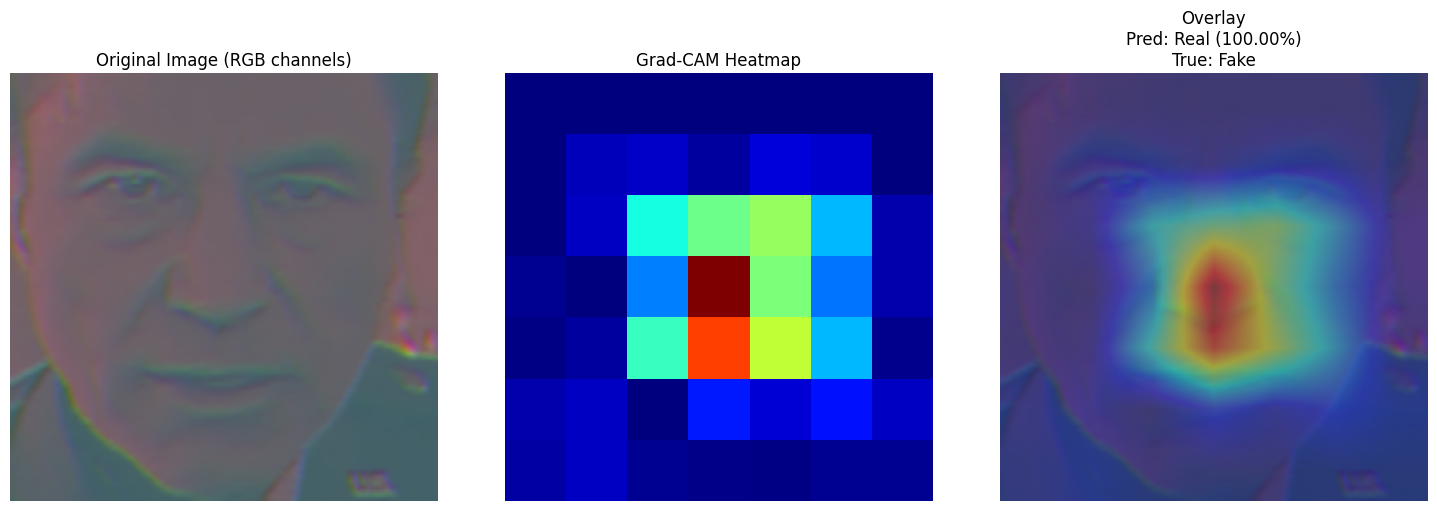

In [26]:
print(f"Loaded {len(dataset)} images")

# Load model
model = ResNetClassifier.load_from_checkpoint(MODEL_PATH)
model.eval()

# Select target layer for Grad-CAM (typically the last conv layer)
# Example for ResNet: target_layer = model.model.layer4[-1]
# Example for EfficientNet: target_layer = model.model.features[-1]
# Adjust based on your model architecture
target_layer = model.model.layer4[-1]  # Change this to match your model

# Run predictions with Grad-CAM
results = predict_with_gradcam(
    model=model,
    dataloader=dataloader,
    target_layer=target_layer,
    device=DEVICE,
    save_dir=grad_cam_dir
)

In [ ]:
# Print summary
total = len(results)
print("results", results)
correct = sum(1 for r in results if r['correct'])
accuracy = correct / total * 100

print(f"\n{'='*50}")
print(f"Results Summary:")
print(f"Total images: {total}")
print(f"Correct predictions: {correct}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Grad-CAM visualizations saved to: gradcam_results/")
print(f"{'='*50}")